# 2-1 质量控制

我们前面的介绍让你对单细胞测序数据有了一个初步的认识，接下来我们将从另一个角度去认识单细胞测序的数据。

- 1）由于测序深度的限制，受限于基因自身的表达量，我们会发现单细胞测序数据是一个有很多“0”值的矩阵，我们称这种现象为“drop-out”，这些零一方面可能是测序深度不够导致基因没有捕获到，另一方面可能是这些基因本身没有表达。
- 2）由于细胞状态的不同，单细胞测序数据中将包含一些即将死亡的细胞，这些细胞自身的生物学意义还有待探究，但通常被认为会引入不必要的生物学误差。
- 3）由于测序技术的原因，可能会出现一个孔内包含了两个细胞，这种情况下，我们测得的细胞的基因表达量将会异常地高。正常细胞的基因表达量通常在3000-4000左右。

以上原因，使得我们所获得的单细胞测序数据不是完美的，我们需要对数据进行质量控制，避免影响我们发现有意义的生物学结果。但是不同的预处理方法可能会带来不同的效果，单细胞测序分析技术的快速发展使得我们有大量的工具可以对单细胞测序数据进行质量控制。在本小节中，我们将详细描述`质量控制`的最佳步骤。

## 1. 环境配置与数据

我们将使用在NeurIPS 2021会议上[Luecken等人，2021]的一个10x Multiome数据集。该数据集捕获了来自12名健康人类供体的骨髓单核细胞的单细胞多组学数据，该数据集捕获了在四个不同地点测量的 12 名健康人类捐赠者的骨髓单核细胞的单细胞多组学数据，以获得嵌套批次效应。在本教程中，我们将使用一批上述数据集（供体 8 的样本 4）来展示 scRNA-seq 数据预处理的最佳实践。

我们先导入环境

In [1]:
import omicverse as ov
import scanpy as sc

ov.utils.ov_plot_set()

第一步，我们使用`scanpy`加载来自Figshare上托管的数据集。

In [2]:
adata = sc.read_10x_h5(
    filename="filtered_feature_bc_matrix.h5",
    backup_url="https://figshare.com/ndownloader/files/39546196",
)
adata

reading filtered_feature_bc_matrix.h5
try downloading from url
https://figshare.com/ndownloader/files/39546196
... this may take a while but only happens once


  0%|          | 0.00/163M [00:00<?, ?B/s]

 (0:00:25)


AnnData object with n_obs × n_vars = 16934 × 36601
    var: 'gene_ids', 'feature_types', 'genome'

读取数据后，scanpy 会显示一条警告，指出并非所有变量名称都是唯一的。这表明某些var（=基因）出现多次，这可能会导致下游分析任务出现错误或意外行为。我们执行建议的函数`var_names_make_unique()`，通过将数字字符串附加到每个重复的索引元素（“1”、“2”等）来使变量名称唯一。

同样地，我们也可以使用`obs_names_make_unique()`来使obs（=细胞）唯一

In [3]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

The dataset has the shape n_obs 16,934 x n_vars 36,601. This translates into barcodes x number of transcripts. We additionally inspect further information in .var in terms of gene_ids (Ensembl Id), feature_types and genome.

数据集的形状为n_obs 16,934 x n_vars 36,601，这代表了 细胞标签 x 转录本数量 =  16,934 x 36,601。同时我们注意到，var里面有三个元素'gene_ids', 'feature_types', 'genome'，其分别意味着来自Ensembl的基因id，类型，还有基因组的名字，我们使用`.head()`可视化即可知道数据内容。

In [4]:
adata.var.head()

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38


大多数下游的分析任务都假设数据集中的每个obs代表来自一个完整单细胞的测量值。在某些情况下，这种假设可能被低质量的细胞、无细胞 RNA 的污染或双重细胞所破坏。本教程将指导您如何纠正和消除干扰，并获得高质量的数据集。

![img](https://www.sc-best-practices.org/_images/quality_control.jpeg)

## 2. 过滤低质量的细胞

质量控制的第一步是过滤低质量的细胞。当细胞检测到的基因数量较少、计数深度较低且线粒体计数较高时，细胞膜可能会破裂，这表明细胞正在死亡。由于这些细胞通常不是我们分析的主要目标，并且可能会扭曲我们的下游分析，因此我们在质量控制过程中将其去除。为了识别它们，我们定义了细胞质量控制（QC）阈值。细胞质控通常对以下三个质控协变量进行：

- 每个条形码的计数数量（计数深度）
- 每个条形码的基因数量
- 每个条形码的线粒体基因计数比例

如果一个细胞正在死亡，那么其mRNA被释放到内环境，导致线粒体基因的比例较高，所以我们可以通过线粒体基因的比例来过滤掉低质量的单细胞测序数据。但是如果仅考虑一个变量可能会造成生物学误差，共同考虑三个 QC 协变量至关重要。例如，线粒体计数相对较高的细胞可能参与呼吸过程，不应被过滤掉。然而，计数低或高的细胞可能对应于静止细胞群或尺寸较大的细胞。故我们在过滤低质量细胞的时候，要同时考虑不同的QC协变量之间的关系。

一般来说，对于简单的数据，我们可以观察数据的分布，进而确定协变量过滤的阈值。但随着数据集规模的增长，手动观察可能会比较耗时，在这里，我们可以通过 MAD (中值绝对偏差)自动设定过滤的阈值。如果细胞的计数大于5倍的MAD，我们可以认为这是一个异常值。

在 QC 中，第一步是计算 QC 协变量或度量。我们使用`scanpy`函数 `sc.pp.calculate_qc_metrics` 来计算协变量，该函数还可以计算特定基因群体的计数比例。例如，我们定义线粒体，核糖体和血红蛋白基因。值得注意的是，根据数据集中考虑的物种，线粒体计数被注释为前缀“ MT-”或“ MT-”。如前所述，这个教程中使用的数据集是人类骨髓，因此线粒体计数是以“ MT-”前缀注释的。对于鼠标数据集，前缀通常是小写，因此“ mt-”。


In [5]:
# 线粒体基因
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# 核糖体基因
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# 血红蛋白基因
adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))

In [6]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

除了使用`sc.pp.calculate_qc_metrics`来计算协变量外，我们还可以手动计算。在这里，我们首先需要判断单细胞测序的矩阵格式，我们使用scipy.sparse的`issparse`来进行判断

In [7]:
from scipy.sparse import issparse
if issparse(adata.X):
    adata.obs['nUMIs'] = adata.X.toarray().sum(axis=1)  
    adata.obs['mito_perc'] = adata[:, adata.var["mt"]].X.toarray().sum(axis=1) / adata.obs['nUMIs'].values
    adata.obs['detected_genes'] = (adata.X.toarray() > 0).sum(axis=1)  
else:
    adata.obs['nUMIs'] = adata.X.sum(axis=1)  
    adata.obs['mito_perc'] = adata[:, adata.var["mt"]].X.sum(axis=1) / adata.obs['nUMIs'].values
    adata.obs['detected_genes'] = (adata.X > 0).sum(axis=1)  

adata

AnnData object with n_obs × n_vars = 16934 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

我们对比['nUMIs','total_counts','n_genes_by_counts','detected_genes','pct_counts_mt','mito_perc',]变量发现，手动计算与自动计算的结果是一样的。

In [11]:
adata.obs[['nUMIs','total_counts','n_genes_by_counts','detected_genes','pct_counts_mt','mito_perc',]]

,nUMIs,total_counts,n_genes_by_counts,detected_genes,pct_counts_mt,mito_perc
AAACAGCCAAGCTTAT-1,2243.0,2243.0,1362,1362,0.802497,0.008025
AAACAGCCATAGCTTG-1,4085.0,4085.0,2126,2126,1.542228,0.015422
AAACAGCCATGAAATG-1,3050.0,3050.0,899,899,1.836066,0.018361
AAACAGCCATGTTTGG-1,2227.0,2227.0,1340,1340,1.347104,0.013471
AAACATGCAACGTGCT-1,1211.0,1211.0,828,828,1.651528,0.016515
...,...,...,...,...,...,...
TTTGTTGGTGGCTTCC-1,1367.0,1367.0,925,925,1.389905,0.013899
TTTGTTGGTTCTTTAG-1,7961.0,7961.0,3417,3417,0.678307,0.006783
TTTGTTGGTTGGCCGA-1,1316.0,1316.0,925,925,1.063830,0.010638
TTTGTTGGTTTACTTG-1,2466.0,2466.0,1406,1406,1.013788,0.010138


我们对这三个变量进行解释：

- n_genes_by_counts/detected_genes: 一个细胞中发现的有效基因数量（即表达量不为0）
- total_counts/nUMIs: 一个细胞中发现的分子数量（UMI），通常也可以被认为是这个细胞的文库大小
- pct_counts_mt/mito_perc: 一个细胞中线粒体基因的表达计数占比

我们可以绘制三个协变量的分布图，来让我们更加直观地了解这三个协变量

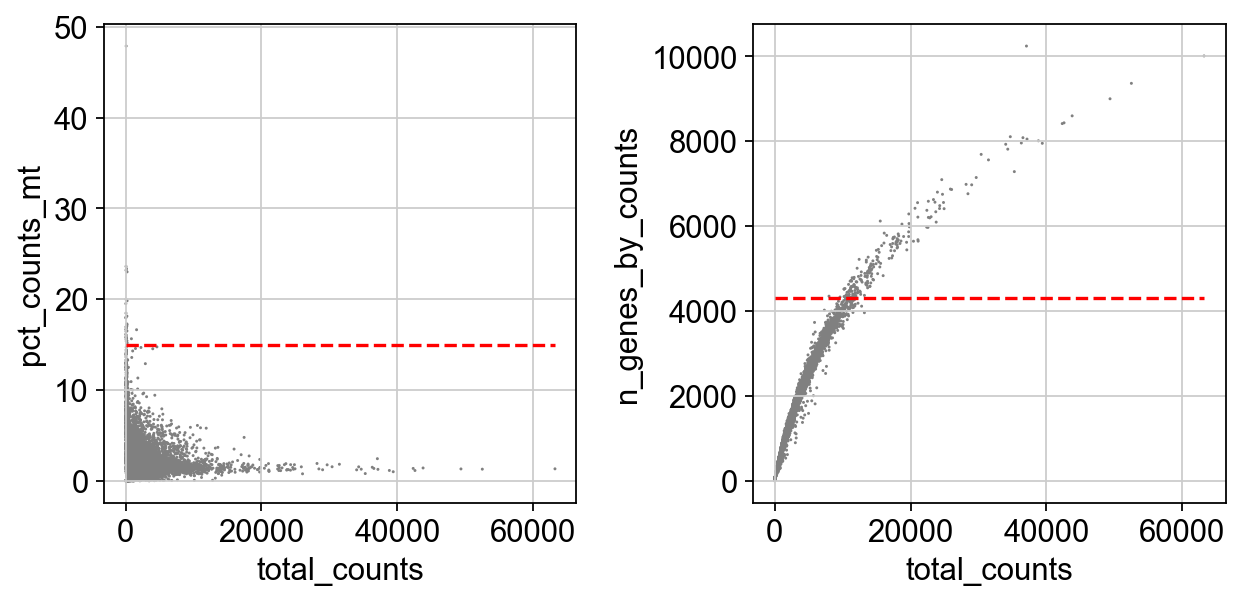

In [19]:
import matplotlib.pyplot as plt
mito_filter = 15
n_counts_filter = 4300
fig, axs = plt.subplots(ncols = 2, figsize = (8,4))
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',ax = axs[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',ax = axs[1], show = False)
#draw horizontal red lines indicating thresholds.
axs[0].hlines(y = mito_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
axs[1].hlines(y = n_counts_filter, xmin = 0, xmax = max(adata.obs['total_counts']), color = 'red', ls = 'dashed')
fig.tight_layout()
plt.show()

在`scanpy`的官方教程中，高计数的细胞被认为是双细胞进而过滤，所以我们绘制了两条红线，但在我们的教程中，对于双细胞我们将采用其他方法进行过滤，所以我们只需要对一些低表达的细胞进行质控，比如nUMI小于500的细胞，比如detected_gene小于250的细胞，线粒体基因的计数比例不超过15%。但这个过滤我们要在双细胞过滤完后再进行。

In [20]:
# Original QC plot
n0 = adata.shape[0]
print(f'Original cell number: {n0}')

Original cell number: 16934


## 3. 双细胞的过滤

双细胞被定义为在相同的细胞条形码（barcode）下进行测序的两个细胞，例如，如果它们被捕获在同一个液滴（droplet）中。这也是为什么我们一直使用barcode而不是cells的原因。双细胞由同型（homotypic）与异型（heterotypic）所构成

- 同型：同型通常被认为是不影响下游分析的，因为其是由一类相同的细胞中的两个所构成，所以这部分细胞不是我们所需要过滤的对象
- 异型：异型通常是由来自两类不同的细胞所构成的，异型的存在会使得我们后续的细胞分类出现错误，因为其独特的数据分布特征。

我们可以通过人工构建双细胞进行模拟识别，以排除异型的存在。在本教程中，我们将使用`scrublet`来完成双细胞的识别。

![双细胞](https://www.sc-best-practices.org/_images/doublet_detection.jpeg)


In [23]:
print('Begin of post doublets removal and QC plot')
sc.external.pp.scrublet(adata, random_state=112)
adata = adata[adata.obs['predicted_doublet']==False, :].copy()
n1 = adata.shape[0]
print(f'Cells retained after scrublet: {n1}, {n0-n1} removed.')
print(f'End of post doublets removal and QC plots.')

Begin of post doublets removal and QC plot
Running Scrublet
filtered out 7737 genes that are detected in less than 3 cells
filtered out 1 cells that have less than 3 genes expressed
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 16.7%
    Scrublet finished (0:00:20)
Cells retained after scrublet: 16931, 3 removed.
End of post doublets removal and QC plots.


## 4. 手动/自动过滤低质量读数细胞

在第二小节我们介绍了低质量读数的细胞的过滤思想，在本小节中，我们将演示手动与自动过滤低质量读书的细胞的步骤。我们首先将`adata`复制成两份

In [24]:
adata_manual=adata.copy()
adata_auto=adata.copy()

### 4.1 手动过滤低质量读数的细胞

我们首先定义一个过滤字典：`tresh={'mito_perc': 0.15, 'nUMIs': 500, 'detected_genes': 250}`，接着，我们使用该过滤字典完成过滤操作

In [26]:
import numpy as np
tresh={'mito_perc': 0.15, 'nUMIs': 500, 'detected_genes': 250}

adata_manual.obs['passing_mt'] = adata_manual.obs['mito_perc'] < tresh['mito_perc']
adata_manual.obs['passing_nUMIs'] = adata_manual.obs['nUMIs'] > tresh['nUMIs']
adata_manual.obs['passing_ngenes'] = adata_manual.obs['detected_genes'] > tresh['detected_genes']

print(f'Lower treshold, nUMIs: {tresh["nUMIs"]}; filtered-out-cells: {n1-np.sum(adata_manual.obs["passing_nUMIs"])}')
print(f'Lower treshold, n genes: {tresh["detected_genes"]}; filtered-out-cells: {n1-np.sum(adata_manual.obs["passing_ngenes"])}')
print(f'Lower treshold, mito %: {tresh["mito_perc"]}; filtered-out-cells: {n1-np.sum(adata_manual.obs["passing_mt"])}')

Lower treshold, nUMIs: 500; filtered-out-cells: 2884
Lower treshold, n genes: 250; filtered-out-cells: 1104
Lower treshold, mito %: 0.15; filtered-out-cells: 33


我们需要对数据取保留的细胞的交集

In [27]:
QC_test = (adata_manual.obs['passing_mt']) & (adata_manual.obs['passing_nUMIs']) & (adata_manual.obs['passing_ngenes'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last  QC (and its chosen options): {n1-np.sum(QC_test)}')
adata_manual = adata_manual[QC_test, :].copy()
n2 = adata_manual.shape[0]
    
# Store cleaned adata
print(f'Cells retained after scrublet and filtering: {n2}, {n0-n2} removed.')

Total cell filtered out with this last  QC (and its chosen options): 2887
Cells retained after scrublet and filtering: 14044, 2890 removed.


自此，我们完成了污染去除，但是，我们还需要过滤掉一些从基因和细胞层面低计数的细胞/基因

In [32]:
# Last gene and cell filter
sc.pp.filter_cells(adata_manual, min_genes=200)
sc.pp.filter_genes(adata_manual, min_cells=3)

adata_manual

filtered out 7824 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 14044 × 28777
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

### 4.2 自动过滤低质量读数的细胞

即使是自动过滤，我们也得首先设定好基础阈值，即`tresh={'mito_perc': 0.15, 'nUMIs': 500, 'detected_genes': 250}`，我们在omicverse里，预先设定好了`ov.pp._qc.mads`和`ov.pp._qc.mads_test`两个函数，来计算MAD值。


In [30]:
adata_auto.obs['passing_mt'] = adata_auto.obs['mito_perc'] < tresh['mito_perc']
adata_auto.obs['passing_nUMIs'] = ov.pp._qc.mads_test(adata_auto.obs, 'nUMIs', nmads=5, lt=tresh)
adata_auto.obs['passing_ngenes'] = ov.pp._qc.mads_test(adata_auto.obs, 'detected_genes', nmads=5, lt=tresh)  

nUMIs_t = ov.pp._qc.mads(adata_auto.obs, 'nUMIs', nmads=5, lt=tresh)
n_genes_t = ov.pp._qc.mads(adata_auto.obs, 'detected_genes', nmads=5, lt=tresh)
print(f'Tresholds used, nUMIs: ({nUMIs_t[0]}, {nUMIs_t[1]}); filtered-out-cells: {n1-np.sum(adata_auto.obs["passing_nUMIs"])}')
print(f'Tresholds used, n genes: ({n_genes_t[0]}, {n_genes_t[1]}); filtered-out-cells: {n1-np.sum(adata_auto.obs["passing_ngenes"])}')
print(f'Lower treshold, mito %: {tresh["mito_perc"]}; filtered-out-cells: {n1-np.sum(adata_auto.obs["passing_mt"])}')

Tresholds used, nUMIs: (500, 4247.0); filtered-out-cells: 4396
Tresholds used, n genes: (250, 2622.0); filtered-out-cells: 2211
Lower treshold, mito %: 0.15; filtered-out-cells: 33


同理，我们对需要保留的细胞取交集

In [31]:
QC_test = (adata_auto.obs['passing_mt']) & (adata_auto.obs['passing_nUMIs']) & (adata_auto.obs['passing_ngenes'])
removed = QC_test.loc[lambda x : x == False]
print(f'Total cell filtered out with this last  QC (and its chosen options): {n1-np.sum(QC_test)}')
adata_auto = adata_auto[QC_test, :].copy()
n2 = adata_auto.shape[0]
    
# Store cleaned adata
print(f'Cells retained after scrublet and filtering: {n2}, {n0-n2} removed.')

Total cell filtered out with this last  QC (and its chosen options): 4399
Cells retained after scrublet and filtering: 12532, 4402 removed.


自此，我们完成了污染去除，但是，我们还需要过滤掉一些从基因和细胞层面低计数的细胞/基因

In [33]:
# Last gene and cell filter
sc.pp.filter_cells(adata_auto, min_genes=200)
sc.pp.filter_genes(adata_auto, min_cells=3)

adata_auto

filtered out 9772 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 12532 × 26829
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

我们会发现，自动过滤会比手动过滤去除掉更多的细胞，这是因MAD的识别完全从数据的角度出发，去除了离群的值，但是我们手动过滤没有对离群的值进行过滤，而是全部保留。当然，在omicverse中，我们提供了`ov.pp.qc`函数来完成质控的所有步骤。该函数的参数如下：

- `mode`: 我们可以指定为`'seurat'`或`'mads'`,如果为seurat，那么则是执行上面的手动过滤步骤，如果是mads，则是自动过滤步骤
- `min_cells`: 一个基因最少在多少个细胞中表达，如果设定为3，那么意味着表达少于3个细胞的基因都将被过滤掉
- `min_genes`: 一个细胞最少表达多少个基因，如果设定为200，那么意味着表达量小于200的细胞都将被过滤掉
- `nmads`: MADs的倍数，前面有阐述，默认5倍为离群值
- `tresh`=None

如果tresh==None，那么其自动设置为`{'mito_perc': 0.15, 'nUMIs': 500, 'detected_genes': 250}`

In [35]:
adata=ov.pp.qc(adata,
         tresh={'mito_perc': 0.05, 'nUMIs': 500, 'detected_genes': 250})
adata

Calculate QC metrics
End calculation of QC metrics.
Original cell number: 16931
Begin of post doublets removal and QC plot
Running Scrublet
filtered out 7737 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.54
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 0.1%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 13.3%
    Scrublet finished (0:00:22)
Cells retained after scrublet: 16929, 2 removed.
End of post doublets removal and QC plots.
Filters application (seurat or mads)
Lower tresh

AnnData object with n_obs × n_vars = 13709 × 28707
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'nUMIs', 'mito_perc', 'detected_genes', 'doublet_score', 'predicted_doublet', 'cell_complexity', 'passing_mt', 'passing_nUMIs', 'passing_ngenes', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'scrublet'

## 5. 环境 RNA 的校正

注：本节可能会导致计数矩阵不为整数，使得部分包失效，所以该分析除非你很明确环境RNA的干扰十分严重，不然我认为是可以被跳过的。

对于基于液滴的单细胞 RNA-seq 实验，一定数量的背景 mRNA 存在于稀释液中，与细胞一起分布在液滴中，并随之测序。这样做的最终结果是产生一种背景污染，这种污染表现的不是液滴中所含细胞的表达，而是包含细胞的溶液。

基于液滴的 scRNA-seq 为多个细胞的基因产生独特的分子标识符(UMI)计数，目的是确定每个基因和每个细胞的分子数量。它假设每个液滴都含有来自单个细胞的 mRNA。重复，空液滴和无细胞 RNA 可以打破这一假设。无细胞的 mRNA 分子代表存在于稀释液中的背景 mRNA。这些分子沿着液滴分布，并与它们一起测序。输入溶液中这种无细胞 mRNA 的污染通常被称为细胞溶解产生的“soup”。

![soupx](https://www.sc-best-practices.org/_images/ambient_rna.jpeg)

无细胞的 mRNA 分子，也被称为环境 RNA，可以混淆观察到的计数的数量，可以被看作是背景污染。对于无细胞 mRNA，纠正基于液滴的 scRNA-seq 数据集非常重要，因为它可能会扭曲我们下游分析中数据的解释。通常，每个输入解决方案的“汤”都不相同，并且取决于数据集中各个单元格之间的表达式模式.

在这里，我们推荐使用`soupX`包来完成环境RNA的校正，由于环境RNA的校正需要用到`raw_feature_bc_matrix`文件，该文件大部分文章都不会上传到公开数据集，所以感兴趣的读者可以自行研究soupX的教程。或者从单细胞最佳实践的英文版教程中完成该分析：https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html

## 6. 思考

- 低质量细胞包括哪几种类型？
- 我们在过滤低质量细胞的时候使用了哪些指标？指标的含义分别是？
- 双细胞有哪几种类型？不同类型背后的生物学意义是什么？